In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from residual_model import ResidualBlock, ResidualModel
from transmission_model import TransmissionModel

In [7]:
def dehaze_image(image):
    """
    Full model for image dehazing

    Input: image - input haze image
    Output: haze_free_image - output dehaze image
    """

    input_image_orig = np.asarray(Image.open(image)) / 255.0
    input_image = np.pad(input_image_orig, ((7, 8), (7, 8), (0, 0)), 'symmetric')

    trans_model = TransmissionModel()
    trans_model.load_state_dict(torch.load('/Users/daniilskrabo/Desktop/Practice STC/Image-Dehazing/data/trans_model_weights.pt', map_location = torch.device('cpu')))

    input_image = np.expand_dims(input_image.transpose(2, 0, 1), axis = 0)
    trans_map_orig = trans_model(torch.tensor(input_image).float())
    trans_map = trans_map_orig.squeeze((0,1)).detach().numpy()
    trans_map_refine = trans_model.transmission_refine((input_image_orig * 255.0).astype('uint8'), trans_map)

    res_map_input = input_image_orig / np.expand_dims(trans_map_refine, axis = (0, 3))

    res_model = ResidualModel()
    res_model.load_state_dict(torch.load('/Users/daniilskrabo/Desktop/Practice STC/Image-Dehazing/data/res_model_weights.pt', map_location = torch.device('cpu')))
    res_map_output = res_model(np.clip(torch.tensor(res_map_input.transpose(0, 3, 1, 2)).float(), 0, 1))

    haze_free_image = (res_map_input.squeeze(0) - res_map_output.squeeze(0).detach().numpy().transpose(1, 2, 0))
    haze_free_image = np.clip(haze_free_image, 0, 1)

    return haze_free_image

In [11]:
input_image_orig = np.asarray(Image.open('/Users/daniilskrabo/Desktop/Practice STC/Image-Dehazing/data/cones.jpg')) / 255.0
input_image = np.pad(input_image_orig, ((7, 8), (7, 8), (0, 0)), 'symmetric')

trans_model = TransmissionModel()
trans_model.load_state_dict(torch.load('/Users/daniilskrabo/Desktop/Practice STC/Image-Dehazing/data/trans_model_weights.pt', map_location = torch.device('cpu')))

input_image = np.expand_dims(input_image.transpose(2, 0, 1), axis = 0)
trans_map_orig = trans_model(torch.tensor(input_image).float())
trans_map = trans_map_orig.squeeze((0,1)).detach().numpy()
trans_map_refine = trans_model.transmission_refine((input_image_orig * 255.0).astype('uint8'), trans_map)

res_map_input = input_image_orig / np.expand_dims(trans_map_refine, axis = (0, 3))

res_model = ResidualModel()
res_model.load_state_dict(torch.load('/Users/daniilskrabo/Desktop/Practice STC/Image-Dehazing/data/res_model_weights.pt', map_location = torch.device('cpu')))
res_map_output = res_model(np.clip(torch.tensor(res_map_input.transpose(0, 3, 1, 2)).float(), 0, 1))

haze_free_image = (res_map_input.squeeze(0) - res_map_output.squeeze(0).detach().numpy().transpose(1, 2, 0))
haze_free_image = np.clip(haze_free_image, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Dehaze image')

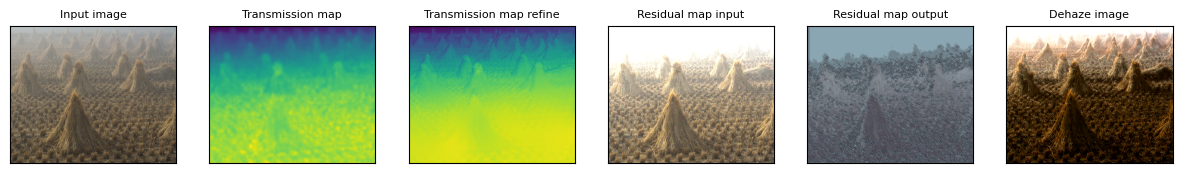

In [17]:
fig, axes = plt.subplots(1, 6, figsize = (15, 8))
axes[0].imshow(input_image_orig)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Input image', size = 8)
axes[1].imshow(trans_map)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Transmission map', size = 8)
axes[2].imshow(trans_map_refine)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Transmission map refine', size = 8)
axes[3].imshow(res_map_input.squeeze(0))
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title('Residual map input', size = 8)
axes[4].imshow(res_map_output.squeeze(0).detach().numpy().transpose(1, 2, 0))
axes[4].set_xticks([])
axes[4].set_yticks([])
axes[4].set_title('Residual map output', size = 8)
axes[5].imshow(haze_free_image)
axes[5].set_xticks([])
axes[5].set_yticks([])
axes[5].set_title('Dehaze image', size = 8)